In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os
import matplotlib.ticker as mtick

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import re


from sklearn.model_selection import train_test_split

# K Means Clustering
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

# DT 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV 

# Boosted DT 
from sklearn.ensemble import AdaBoostRegressor

# Scaler for ANN
from sklearn.preprocessing import StandardScaler

# ANN
from sklearn.neural_network import MLPRegressor

# KMeans 
from sklearn.cluster import KMeans

import scipy

In [2]:
os.listdir()


['Movie_Rankings.csv',
 'imdb_updated',
 'Movies.ipynb',
 'Movies_2020.xlsx',
 '.DS_Store',
 'Archive',
 'Movies_Ranked.csv',
 'Movies_Updated.ipynb',
 'IMDB',
 '.ipynb_checkpoints',
 'Movies - Personal Inquiry.ipynb',
 'Movies.csv',
 'MLR_Movies.ipynb']

In [3]:
data = pd.read_excel('Movies_2020.xlsx', 
                    dtype = {'ReleaseYear': int}
                    )

In [4]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre
0,Star Wars: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama


In [5]:
print("There are ",data.shape[0], " movies in this dataset")

There are  157  movies in this dataset


In [6]:
data.dtypes

Name                   object
Rating                float64
WatchDate      datetime64[ns]
ReleaseYear             int64
Director               object
Genre                  object
dtype: object

In [7]:
data.isna().sum()

Name           0
Rating         0
WatchDate      0
ReleaseYear    0
Director       0
Genre          0
dtype: int64

#### The movie watchings are skewed heavily toward recent movies, with some noticable peaks in 1950s (due to Hitchcock & Audrey Hepburn films)

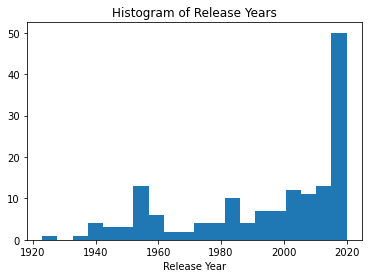

In [8]:
plt.hist(data['ReleaseYear'], bins = 20)
plt.xlabel('Release Year')
plt.title("Histogram of Release Years")
plt.show()

#### The Ratings also show that I generally rate movies highly, this distribution is right-skewed as well

In [9]:
data['Rating'].describe()

count    157.000000
mean       0.795987
std        0.132112
min        0.300000
25%        0.720000
50%        0.850000
75%        0.900000
max        0.990000
Name: Rating, dtype: float64

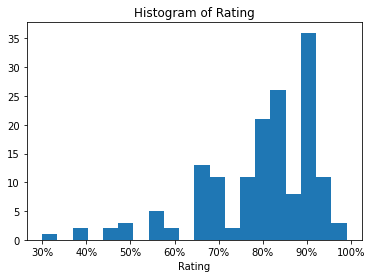

In [10]:
plt.hist(data['Rating'], bins = 20)
plt.xlabel('Rating')
plt.title("Histogram of Rating")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

#### My movie intake is quite high during the 2020 Global Covid-19 Pandemic. It also was pretty high in early 2016, as I was in my senior spring of college. This charts the quarterly sum of movies. 

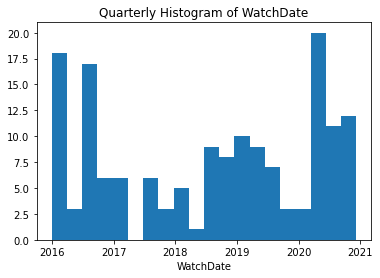

In [11]:
plt.hist(data['WatchDate'], bins = 20)
plt.xlabel('WatchDate')
plt.title("Quarterly Histogram of WatchDate")
plt.show()

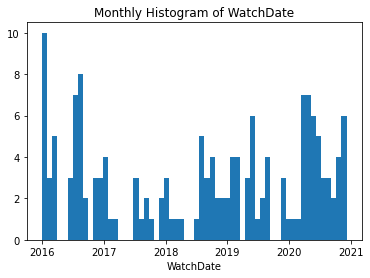

In [12]:
plt.hist(data['WatchDate'], bins = 60)
plt.xlabel('WatchDate')
plt.title("Monthly Histogram of WatchDate")
plt.show()

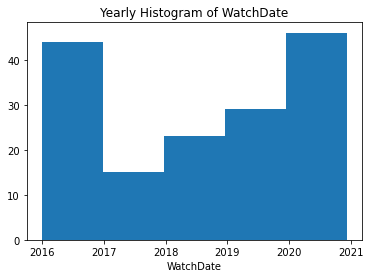

In [13]:
plt.hist(data['WatchDate'], bins = 5)
plt.xlabel('WatchDate')
plt.title("Yearly Histogram of WatchDate")
plt.show()

#### What is my average rating over time?

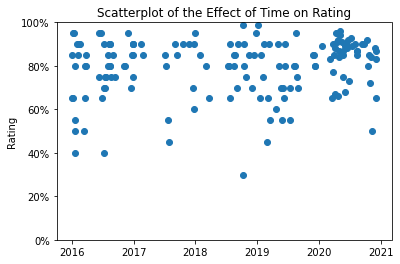

In [14]:
plt.scatter(data['WatchDate'], data['Rating'])
plt.title("Scatterplot of the Effect of Time on Rating")
plt.ylabel('Rating')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

#### Am I watching newer movies over time?

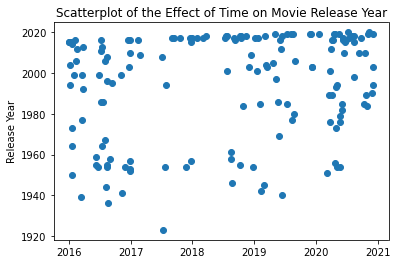

In [15]:
plt.scatter(data['WatchDate'], data['ReleaseYear'])
plt.title("Scatterplot of the Effect of Time on Movie Release Year")
plt.ylabel('Release Year')
plt.show()

#### Create a Monthly Aggregation to Summarize Trends

In [16]:

data['WatchMonth'] = data['WatchDate'].values.astype('datetime64[M]')

data_month = data.groupby(['WatchMonth']).agg(
                    count = pd.NamedAgg( column = 'Name', aggfunc = 'count'),
                    rating = pd.NamedAgg( column = 'Rating', aggfunc = 'mean'),
                    movieyear = pd.NamedAgg( column = 'ReleaseYear', aggfunc = 'mean')
                )
data_month = data_month.reset_index()
#data_month.rename(columns = {'Name':'Count'}, inplace = True)
data_month.head()


,WatchMonth,count,rating,movieyear
0,2016-01-01,10,0.720000,1994.300000
1,2016-02-01,3,0.883333,2011.333333
2,2016-03-01,5,0.720000,1984.000000
3,2016-06-01,4,0.825000,1966.750000
4,2016-07-01,6,0.700000,1996.000000


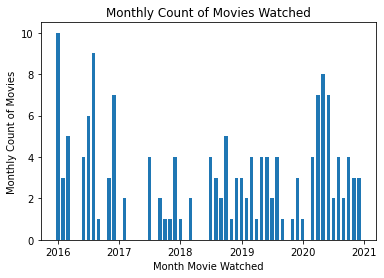

In [17]:
plt.bar(data_month['WatchMonth'], data_month['count'], width = 20)
plt.xlabel('Month Movie Watched')
plt.ylabel('Monthly Count of Movies')
plt.title('Monthly Count of Movies Watched')
plt.show()

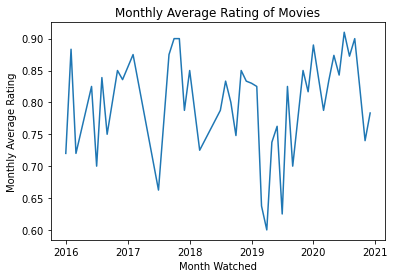

In [18]:
plt.plot(data_month['WatchMonth'], data_month['rating'])
plt.title('Monthly Average Rating of Movies')
plt.xlabel('Month Watched')
plt.ylabel('Monthly Average Rating')
plt.show()

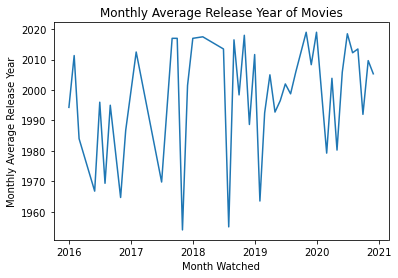

In [19]:
plt.plot(data_month['WatchMonth'], data_month['movieyear'])
plt.title('Monthly Average Release Year of Movies')
plt.xlabel('Month Watched')
plt.ylabel('Monthly Average Release Year')
plt.show()

#### Is there a relationship between Year of the Movie Release and my Rating?

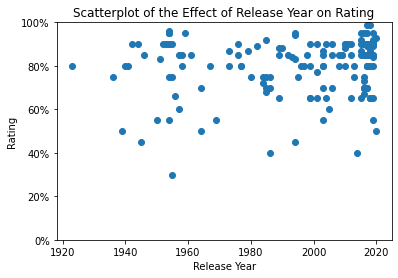

In [20]:
plt.scatter(data['ReleaseYear'], data['Rating'])
plt.title('Scatterplot of the Effect of Release Year on Rating')
plt.xlabel('Release Year')
plt.ylabel('Rating')
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

#### What are my highest rated movies?

In [21]:
data.sort_values(by=['Rating']).tail(5)

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth
120,Hidden figures,0.95,2020-04-10,2016,Theodore Melfi,Drama/History,2020-04-01
105,The Farewell,0.95,2019-08-17,2019,Lulu Wang,Drama/Comedy,2019-08-01
126,The rear window,0.96,2020-05-05,1954,Alfred Hitchcock,Noir/Mystery,2020-05-01
75,Colette,0.99,2018-10-12,2018,Wash Westmoreland,Historical/Drama,2018-10-01
83,On The Basis of Sex,0.99,2019-01-06,2017,Mimi Leder,Historical/Drama,2019-01-01


#### Which Director have I seen the most movies from?

In [22]:
data['Director'].value_counts().head()

Hitchcock          6
Robert Zemeckis    4
Michael Curtiz     4
Damien Chazelle    3
John Hughes        3
Name: Director, dtype: int64

### Label Encoding the Genre Column 

In [23]:
data[['Genre1','Genre2']] = data['Genre'].str.split('/',expand=True)

In [24]:
data['Genre2'] = data['Genre2'].fillna('Genre1')

In [25]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2
0,Star Wars: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama


Due to the mispellings in the underlying dataset, do manual combinations to reduce the dimensionality of the dataset

In [26]:
#data['Genre1'].value_counts()

In [27]:
#data['Genre2'].value_counts()

In [28]:
#data['Genre_Romance'] = 0
#data.loc[ data['Genre'].str.contains('Romance'), 'Genre_Romance'] = 1


data['Romance_Ind'] = 0 
r = re.compile(r'.*(Romance).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Romance_Ind'] = 1
  
data['Comedy_Ind'] = 0 
r = re.compile(r'.*(Comedy).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Comedy_Ind'] = 1
 
data['Drama_Ind'] = 0 
r = re.compile(r'.*(Drama).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Drama_Ind'] = 1

data['Thriller_Ind'] = 0 
r = re.compile(r'.*(Thriller).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Thriller_Ind'] = 1
 
data['Fantasy_Ind'] = 0 
r = re.compile(r'.*(Fantasy).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Fantasy_Ind'] = 1

data['Crime_Ind'] = 0 
r = re.compile(r'.*(Crime).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Crime_Ind'] = 1

data['Sport_Ind'] = 0 
r = re.compile(r'.*(Sport).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Sport_Ind'] = 1

data['Historical_Ind'] = 0 
r = re.compile(r'.*(Historical).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Historical_Ind'] = 1


data['Mystery_Ind'] = 0 
r = re.compile(r'.*(Mystery).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Mystery_Ind'] = 1


data['Action_Ind'] = 0 
r = re.compile(r'.*(Action).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Action_Ind'] = 1


data['Musical_Ind'] = 0 
r = re.compile(r'.*(Musical).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'Musical_Ind'] = 1


data['SciFi_Ind'] = 0 
r = re.compile(r'.*(Sci).*')
data.loc[ data.Genre.apply(lambda x: bool(r.match(x))), 'SciFi_Ind'] = 1

data['Other_Ind'] = 0
data.loc[ (data['Romance_Ind'] == 0) & (data['Comedy_Ind'] == 0) & (data['Drama_Ind'] == 0) & \
          (data['Thriller_Ind'] == 0) & (data['Fantasy_Ind'] == 0) & (data['Crime_Ind'] == 0) & \
         (data['Sport_Ind'] == 0) & (data['Historical_Ind'] == 0) & (data['Mystery_Ind'] == 0) & \
         (data['Action_Ind'] == 0) & (data['Musical_Ind'] == 0 ) & (data['SciFi_Ind'] == 0)
         , 'Other_Ind'] = 1



In [29]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
0,Star Wars: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0


In [30]:
data.describe()

,Rating,ReleaseYear,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,0.795987,1994.076433,0.242038,0.318471,0.560510,0.082803,0.070064,0.057325,0.050955,0.044586,0.108280,0.044586,0.070064,0.070064,0.025478
std,0.132112,25.778281,0.429688,0.467374,0.497913,0.276465,0.256071,0.233206,0.220610,0.207053,0.311728,0.207053,0.256071,0.256071,0.158075
min,0.300000,1923.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.720000,1977.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.850000,2003.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.900000,2016.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.990000,2020.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
data.iloc[:, 8:].sum()

Genre2            ScienceFictionDramaComedyDramaDramaDramaMusica...
Romance_Ind                                                      38
Comedy_Ind                                                       50
Drama_Ind                                                        88
Thriller_Ind                                                     13
Fantasy_Ind                                                      11
Crime_Ind                                                         9
Sport_Ind                                                         8
Historical_Ind                                                    7
Mystery_Ind                                                      17
Action_Ind                                                        7
Musical_Ind                                                      11
SciFi_Ind                                                        11
Other_Ind                                                         4
dtype: object

In [32]:
data.columns

Index(['Name', 'Rating', 'WatchDate', 'ReleaseYear', 'Director', 'Genre',
       'WatchMonth', 'Genre1', 'Genre2', 'Romance_Ind', 'Comedy_Ind',
       'Drama_Ind', 'Thriller_Ind', 'Fantasy_Ind', 'Crime_Ind', 'Sport_Ind',
       'Historical_Ind', 'Mystery_Ind', 'Action_Ind', 'Musical_Ind',
       'SciFi_Ind', 'Other_Ind'],
      dtype='object')

In [33]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
0,Star Wars: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0


#### Split the Data

In [34]:
X = data.loc[:, ['ReleaseYear','Romance_Ind', 'Comedy_Ind',
       'Drama_Ind', 'Thriller_Ind', 'Fantasy_Ind', 'Crime_Ind', 'Sport_Ind',
       'Historical_Ind', 'Mystery_Ind', 'Action_Ind', 'Musical_Ind',
       'SciFi_Ind', 'Other_Ind']]
y = data.loc[:, 'Rating']

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size = .30, train_size = .70, random_state = 42)
    

In [35]:
print(X_Train.shape)
print(Y_Train.shape)
print(X_Test.shape)
print(Y_Test.shape)

(109, 14)
(109,)
(48, 14)
(48,)


In [36]:
X_Train.head()

,ReleaseYear,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind
140,2017,0,0,1,0,0,0,1,0,0,0,0,0,0
11,2006,0,0,1,0,0,0,0,0,1,0,0,0,0
79,2018,0,0,1,0,0,0,0,1,0,0,0,0,0
68,2018,0,0,0,0,0,0,0,0,0,1,0,1,0
149,1989,0,0,0,0,0,0,0,0,0,0,0,1,0


#### We can't do Clustering on a Binary Dataset. We will have to get something else - such as 'Sentiment Score' using NLP Methods. 
#### Get Sentiment using NLTK, then use that as an input to Clustering 

### Decision Tree on Binary Genre + Release Year Data 

#### 1) Decision Tree 

In [37]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train, Y_Train)

Y_Test_Pred = dt_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -0.5373758278145695
Mean Squared Error: 0.012896874999999997


Grid Search for Best Parameters

In [38]:
def make_GridSearchCV_DT(X_Train, Y_Train):
    
    criterions = ['mse', 'mae','friedman_mse']
    splitters = ['best', 'random']
    max_depths = list(np.arange(1, 20, 2))
    min_samples_leaf = list(np.arange(10, 20, 1))

    param_grid = {'criterion': criterions, 'splitter': splitters, 
                  'max_depth': max_depths, 
                  'min_samples_leaf':min_samples_leaf}

    classifier = GridSearchCV(DecisionTreeRegressor(random_state=42),
                       param_grid=param_grid, 
                       #scoring='neg_mean_squared_error',
                       scoring='r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [39]:
make_GridSearchCV_DT(X_Train, Y_Train)

-0.13967487289417457
{'criterion': 'mse', 'max_depth': 3, 'min_samples_leaf': 10, 'splitter': 'random'}


In [40]:
#import sklearn
#sorted(sklearn.metrics.SCORERS.keys())

R2 Score: -0.2792096942717477
Mean Squared Error: 0.010731147990835216


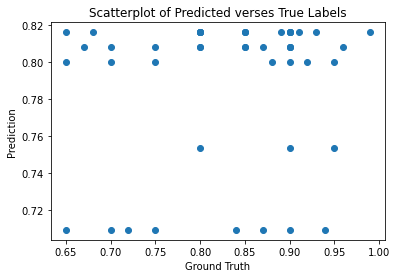

In [41]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'random', 
                                 max_depth = 3, min_samples_leaf = 10,
                                 random_state = 42)

dt_model.fit(X_Train, Y_Train)

Y_Test_Pred = dt_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

plt.scatter(Y_Test, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 2) Boosted Decision Tree

In [42]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 50, learning_rate = 1.0, loss = 'linear', 
                                     random_state = 42)

#Y_Train = Y_Train.ravel()

boosted_dt_model.fit(X_Train, Y_Train)
Y_Test_Pred = boosted_dt_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -0.9800804563854548
Mean Squared Error: 0.01661067493967798


In [43]:
def make_GridSearchCV_Boosted_DT(X_Train, Y_Train):

    losses = ['linear', 'square', 'exponential']
    learning_rates = np.arange(0.5,1,step=0.10)
    num_est = np.arange(10,100,step=5)

    param_grid = {'loss': losses, 'learning_rate': learning_rates, 'n_estimators': num_est}

    classifier = GridSearchCV(AdaBoostRegressor(random_state=42),
                       param_grid=param_grid, 
                       scoring = 'r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [44]:
#make_GridSearchCV_Boosted_DT(X_Train, Y_Train)

R2 Score: -0.28023257036395455
Mean Squared Error: 0.01073972878471984


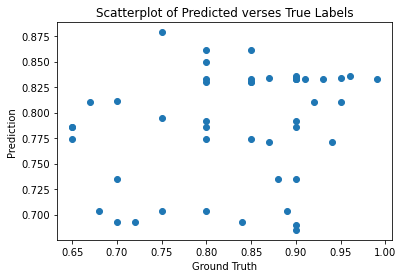

In [45]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 10, learning_rate = 0.5, loss = 'exponential', 
                                     random_state = 42)


boosted_dt_model.fit(X_Train, Y_Train)
Y_Test_Pred = boosted_dt_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

plt.scatter(Y_Test, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 3) Artificial Neural Network

In [46]:
sc = StandardScaler()
X_Train = sc.fit_transform(X_Train)
X_Test = sc.transform(X_Test)

ann_model =  MLPRegressor(activation = 'relu', solver = 'adam', random_state = 42)

ann_model.fit(X_Train, Y_Train)

Y_Test_Pred = ann_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -1.1680559359269433
Mean Squared Error: 0.018187580351387133


In [47]:
# This one is only for the Polling Data 
def make_GridSearchCV_ANN(X_Train, Y_Train):
    
    activations = ['identity', 'relu', 'tanh', 'logistic']
    solvers = ['adam']
    hidden_layers = list(np.arange(5, 100, 5))
    
    init_learning_rates = [0.01, 0.05]
    
    param_grid = {'activation': activations, 'solver': solvers, 'hidden_layer_sizes': hidden_layers,'learning_rate_init': init_learning_rates}

    classifier = GridSearchCV(MLPRegressor(max_iter=2000,random_state=42),
                       param_grid=param_grid, 
                       scoring='r2',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [48]:
#make_GridSearchCV_ANN(X_Train, Y_Train)

R2 Score: -0.8438518933152355
Mean Squared Error: 0.015467868660588918


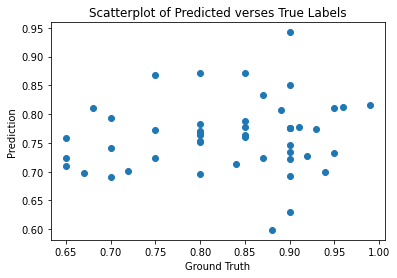

In [49]:
sc = StandardScaler()
X_Train = sc.fit_transform(X_Train)
X_Test = sc.transform(X_Test)

ann_model =  MLPRegressor(activation = 'logistic', solver = 'adam', random_state = 42,
                          hidden_layer_sizes = 45, learning_rate_init = 0.01)

ann_model.fit(X_Train, Y_Train)

Y_Test_Pred = ann_model.predict(X_Test)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

plt.scatter(Y_Test, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### We need to find some better features. Let's explore NLP Sentiment of the Movie Genre

### 1) NLTK Vader Compound Score

### https://www.nltk.org/api/nltk.sentiment.html
### https://github.com/cjhutto/vaderSentiment

If you use the VADER sentiment analysis tools, please cite:

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [50]:
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer


nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def show_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    for key in sorted(ss):
        print('{0}: {1}, '.format(key, ss[key]), end='')
        print()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/amandahutter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [51]:
print(data.loc[0,['Genre1']])

word = str(data.loc[0,['Genre1']])
show_vader_score(word)

Genre1    Fantasy
Name: 0, dtype: object
compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 


In [52]:
for i in range(0, 5):
    print(data.loc[i,['Genre1']])

    word = str(data.loc[i,['Genre1']])
    show_vader_score(word)

Genre1    Fantasy
Name: 0, dtype: object
compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 
Genre1    Fantasy
Name: 1, dtype: object
compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 
Genre1    Romance
Name: 2, dtype: object
compound: 0.5574, 
neg: 0.0, 
neu: 0.581, 
pos: 0.419, 
Genre1    Comedy
Name: 3, dtype: object
compound: 0.3612, 
neg: 0.0, 
neu: 0.667, 
pos: 0.333, 
Genre1    Comedy
Name: 4, dtype: object
compound: 0.3612, 
neg: 0.0, 
neu: 0.667, 
pos: 0.333, 


In [53]:
def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    return (ss['compound'])


In [54]:
get_vader_score('crime')

-0.5423

In [55]:
# Apply this function to my Genre Columns
data['Genre1_NLTK'] = data['Genre1'].apply(get_vader_score)
data['Genre2_NLTK'] = data['Genre2'].apply(get_vader_score)
data['Genre_NLTK'] = (data['Genre1_NLTK'] + data['Genre2_NLTK']) / 2

#### Much of the NLTK Vader Compound Scores are Zero - let us look for a wider range of scores with other Libraries

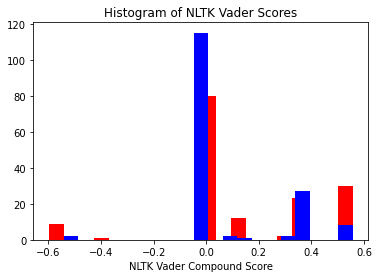

In [56]:
plt.hist(data['Genre1_NLTK'], bins = 20, color = 'red')
plt.hist(data['Genre2_NLTK'], bins = 20, color = 'blue')

plt.xlabel('NLTK Vader Compound Score')
plt.title('Histogram of NLTK Vader Scores')
plt.show()

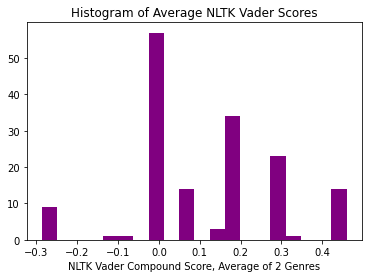

In [57]:
plt.hist(data['Genre_NLTK'], bins = 20, color = 'purple')
plt.xlabel('NLTK Vader Compound Score, Average of 2 Genres')
plt.title('Histogram of Average NLTK Vader Scores')
plt.show()

### 2) Textblob Polarity Score

In [58]:
from textblob import TextBlob

# Get the polarity score using below function
def get_textBlob_score(sent):
    # This polarity score is between -1 to 1
    polarity = TextBlob(sent).sentiment.polarity
    return polarity

In [59]:
data['Genre1_TB'] = data['Genre1'].apply(get_textBlob_score)
data['Genre2_TB'] = data['Genre2'].apply(get_textBlob_score)
data['Genre_TB'] = (data['Genre1_TB'] + data['Genre2_TB']) / 2

#### Textblob Scores are even less spread out than NLTK Vader Scores

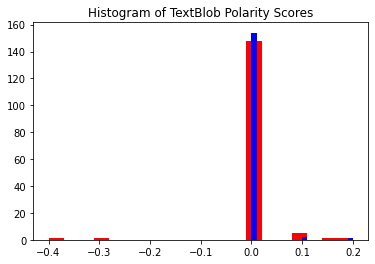

In [60]:
plt.hist(data['Genre1_TB'], bins = 20, color = 'red')
plt.hist(data['Genre2_TB'], bins = 20, color = 'blue')

plt.title('Histogram of TextBlob Polarity Scores')
plt.show()

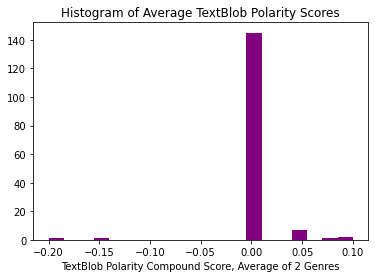

In [61]:
plt.hist(data['Genre_TB'], bins = 20, color = 'purple')
plt.xlabel('TextBlob Polarity Compound Score, Average of 2 Genres')
plt.title('Histogram of Average TextBlob Polarity Scores')
plt.show()

### 3) SpaCy Sentiment 

In [62]:
import spacy



In [63]:
#!python -m spacy download en

#spacy.load('en_core_web_sm')
nlp_spacy = spacy.load('en')

docs = nlp_spacy('romance comedy action crime drama horror musical')

for word in docs:
    print(word.text,word.pos_, word.sentiment)

romance NOUN 0.0
comedy PROPN 0.0
action NOUN 0.0
crime NOUN 0.0
drama NOUN 0.0
horror NOUN 0.0
musical ADJ 0.0


#### Examine NLTK vs Rating

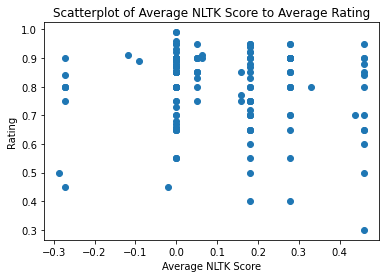

In [64]:
plt.scatter(data['Genre_NLTK'], data['Rating'])
plt.xlabel('Average NLTK Score')
plt.ylabel('Rating')
plt.title('Scatterplot of Average NLTK Score to Average Rating')
plt.show()

#### Examine NLTK vs Release Year

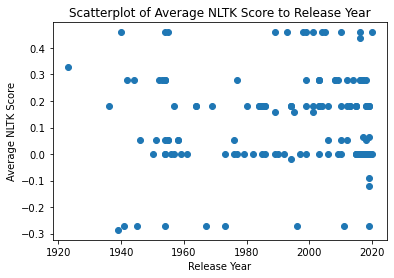

In [65]:
plt.scatter(data['ReleaseYear'], data['Genre_NLTK'])
plt.ylabel('Average NLTK Score')
plt.xlabel('Release Year')
plt.title('Scatterplot of Average NLTK Score to Release Year')
plt.show()

### Revisit Clustering Algorithms, Using NLTK Vader Compound Genre Score + Movie Release Year to Determine the Clusters 

### Cluster Using These Methods:
- K Means
- Expectation Maximization
- Heirarchical

### 1) K-Means

#### How many clusters should we pick? Use Elbow Method 

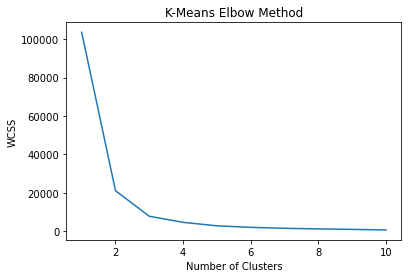

In [66]:
X = data.loc[:, ['ReleaseYear','Genre_NLTK']].values

# Use elbow method to find optimal number of Clusters 

wcss = [] 

# fit KMeans to our data X 
for i in range (1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init = 10, random_state = 43)
    kmeans.fit(X)
    # compute WCSS and append to our list, also called 'Inertia' in KMeans class 
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title('K-Means Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [67]:
#import matplotlib.cm as cm

def run_kmeans(X_Data, range_num_clusters, title):
      
    n_clusters_list = []
    inertia_list = []
    avg_silhouette_list = []
    
    for n_clusters in range_num_clusters:
        kmeans_clusterer =  KMeans(n_clusters = n_clusters, init = 'k-means++', n_init = 10, random_state = 42)
        kmeans_cluster_labels = kmeans_clusterer.fit_predict(X_Data)
        kmeans_silhouette_avg = silhouette_score(X_Data, kmeans_cluster_labels)

        
        n_clusters_list.append(n_clusters)
        inertia_list.append(kmeans_clusterer.inertia_)
        avg_silhouette_list.append(kmeans_silhouette_avg)
        
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(n_clusters_list, inertia_list, 'blue', label = 'Inertia')
    ax1.set_xlabel('Number of Clusters')
    ax1.plot([], [], 'green', label = 'Silhouette Score')
    ax1.legend()
    ax1.set_ylabel('Inertia')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(n_clusters_list, avg_silhouette_list, 'green', label = 'Silhouette Score')
    ax2.set_ylabel('Avg. Silhouette Score')
    plt.grid(False)

    plt.title("The Effect of Number of Clusters \non Inertia and Avg. Silhouette Score  \n for " + title + " with K-Means")
    
    fig.tight_layout()
    plt.show()
    

We want to Maximize Silhouette Score and Minimize Inertia - find place where Inertia is no longer decreasing as fast. 

<Figure size 432x288 with 0 Axes>

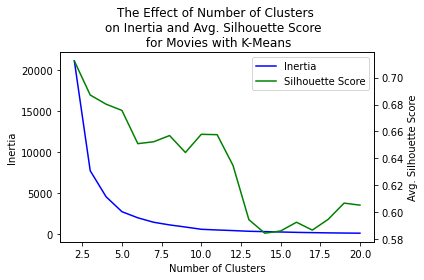

In [68]:
run_kmeans(X, np.arange(2, 21, 1), "Movies")

### K-Means results:
- Elbow method suggests K = 3 clusters
- Silhouette score is still higher for K = 11 clusters

#### K Means with K = 3

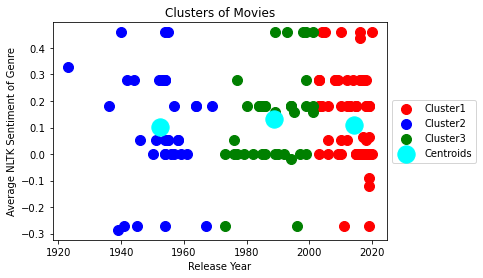

In [69]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', n_init = 10, random_state = 42)
Y_kmeans = kmeans.fit_predict(X)
#print(Y_kmeans)

#print(Y_kmeans.shape)
#print(X.shape)

plt.scatter(X[Y_kmeans == 0, 0], X[Y_kmeans == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_kmeans == 1, 0], X[Y_kmeans == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_kmeans == 2, 0], X[Y_kmeans == 2, 1], s = 100, color = 'green', label = 'Cluster3')

# Add the centroids 
plt.scatter(kmeans.cluster_centers_[:, 0] , kmeans.cluster_centers_[:, 1], s = 300, color = 'cyan', label = 'Centroids')
plt.title('Clusters of Movies')
plt.xlabel('Release Year')
plt.ylabel('Average NLTK Sentiment of Genre')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### K-Means with K = 11

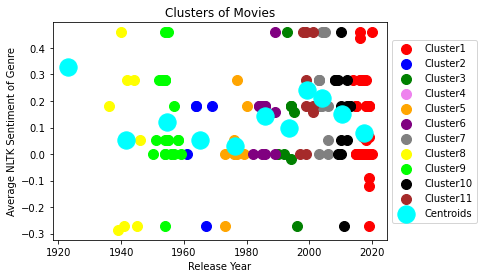

In [70]:
kmeans = KMeans(n_clusters = 11, init = 'k-means++', n_init = 10, random_state = 42)
Y_kmeans = kmeans.fit_predict(X)

plt.scatter(X[Y_kmeans == 0, 0], X[Y_kmeans == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_kmeans == 1, 0], X[Y_kmeans == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_kmeans == 2, 0], X[Y_kmeans == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_kmeans == 3, 0], X[Y_kmeans == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_kmeans == 4, 0], X[Y_kmeans == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_kmeans == 5, 0], X[Y_kmeans == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_kmeans == 6, 0], X[Y_kmeans == 6, 1], s = 100, color = 'gray', label = 'Cluster7')
plt.scatter(X[Y_kmeans == 7, 0], X[Y_kmeans == 7, 1], s = 100, color = 'yellow', label = 'Cluster8')
plt.scatter(X[Y_kmeans == 8, 0], X[Y_kmeans == 8, 1], s = 100, color = 'lime', label = 'Cluster9')
plt.scatter(X[Y_kmeans == 9, 0], X[Y_kmeans == 9, 1], s = 100, color = 'black', label = 'Cluster10')
plt.scatter(X[Y_kmeans == 10, 0], X[Y_kmeans == 10, 1], s = 100, color = 'brown', label = 'Cluster11')


# Add the centroids 
plt.scatter(kmeans.cluster_centers_[:, 0] , kmeans.cluster_centers_[:, 1], s = 300, color = 'cyan', label = 'Centroids')
plt.title('Clusters of Movies')
plt.xlabel('Release Year')
plt.ylabel('Average NLTK Sentiment of Genre')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### The above results are not useful because we did not SCALE the data - only the movie Release Year is dividing up our dataset! 

<Figure size 432x288 with 0 Axes>

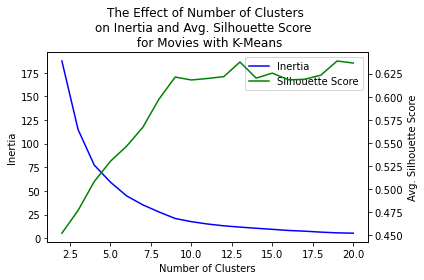

In [71]:
# Use Feature scaling 
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_scaled = sc_X.fit_transform(X)

run_kmeans(X_scaled, np.arange(2, 21, 1), "Movies")

- K = 4 looks like a kink in the elbow, otherwise K = 9 

#### K-Means with K = 4, Scaled Data

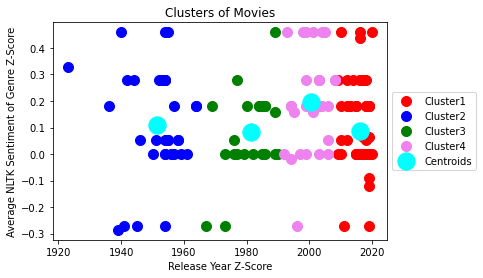

In [72]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, random_state = 42)
Y_kmeans = kmeans.fit_predict(X)

plt.scatter(X[Y_kmeans == 0, 0], X[Y_kmeans == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_kmeans == 1, 0], X[Y_kmeans == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_kmeans == 2, 0], X[Y_kmeans == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_kmeans == 3, 0], X[Y_kmeans == 3, 1], s = 100, color = 'violet', label = 'Cluster4')


# Add the centroids 
plt.scatter(kmeans.cluster_centers_[:, 0] , kmeans.cluster_centers_[:, 1], s = 300, color = 'cyan', label = 'Centroids')
plt.title('Clusters of Movies')
plt.xlabel('Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### K-Means with K = 9, Scaled Data

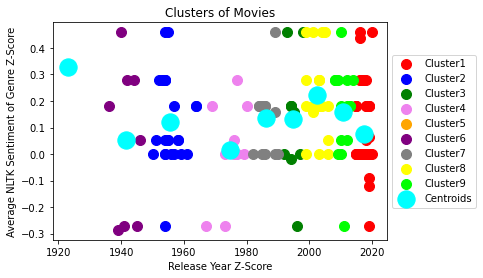

In [73]:
kmeans = KMeans(n_clusters = 9, init = 'k-means++', n_init = 10, random_state = 42)
Y_kmeans = kmeans.fit_predict(X)


plt.scatter(X[Y_kmeans == 0, 0], X[Y_kmeans == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_kmeans == 1, 0], X[Y_kmeans == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_kmeans == 2, 0], X[Y_kmeans == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_kmeans == 3, 0], X[Y_kmeans == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_kmeans == 4, 0], X[Y_kmeans == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_kmeans == 5, 0], X[Y_kmeans == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_kmeans == 6, 0], X[Y_kmeans == 6, 1], s = 100, color = 'gray', label = 'Cluster7')
plt.scatter(X[Y_kmeans == 7, 0], X[Y_kmeans == 7, 1], s = 100, color = 'yellow', label = 'Cluster8')
plt.scatter(X[Y_kmeans == 8, 0], X[Y_kmeans == 8, 1], s = 100, color = 'lime', label = 'Cluster9')

# Add the centroids 
plt.scatter(kmeans.cluster_centers_[:, 0] , kmeans.cluster_centers_[:, 1], s = 300, color = 'cyan', label = 'Centroids')
plt.title('Clusters of Movies')
plt.xlabel('Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [74]:
data['KMeans_Cluster'] = Y_kmeans

In [75]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster
0,Star Wars: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0,0.5574,0.3612,0.4593,0.0,0.0,0.0,7
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.1806,0.0,0.0,0.0,2
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.1806,0.0,0.0,0.0,0


### 2) Expectation Maximization

In [76]:
from sklearn.mixture import GaussianMixture as EM

def run_em(X_Data, k_list, title, cov_type):
    
    aic_list = []
    bic_list = []
    avg_silhouette_list = []
    n_components_list = []
    
    for k in k_list:
        em = EM(n_components = k, covariance_type = cov_type, n_init = 1, init_params = 'kmeans', random_state = 42)
        em_labels = em.fit_predict(X_Data)
        
        n_components_list.append(k)
        avg_silhouette_list.append(silhouette_score(X_Data, em_labels))
        aic_list.append(em.aic(X_Data))
        bic_list.append(em.bic(X_Data))
        
    fig, ax1 = plt.subplots()
    ax1.plot(n_components_list, aic_list, 'blue', label = 'AIC')
    ax1.plot(n_components_list, bic_list, 'green', label = 'BIC')
    ax1.set_xlabel('Number of Components')
    ax1.plot([], [], 'orange', label = 'Silhouette Score')
    ax1.legend()
    ax1.set_ylabel('AIC/BIC Curves')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(n_components_list, avg_silhouette_list, 'orange', label = 'Silhouette Score')
    ax2.set_ylabel('Avg. Silhouette Score')
    plt.grid(False)

    plt.title("The Effect of Number of Components \non BIC/AIC and Avg. Silhouette Score  \nfor " + title + " with EM, "+ cov_type+" Covariance")
    
    fig.tight_layout()
    plt.show()


Covariance type: full


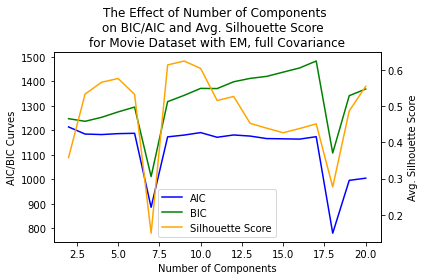

Covariance type: tied


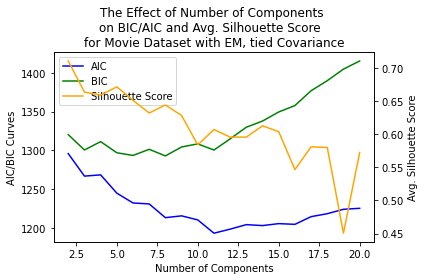

Covariance type: diag


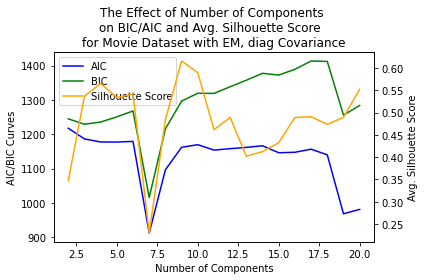

Covariance type: spherical


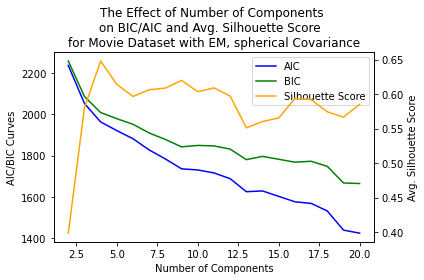

In [77]:
covariance_type = ['full', 'tied', 'diag', 'spherical']

for cv in covariance_type:
    print("Covariance type:", cv)
    run_em(X, np.arange(2, 21, 1), "Movie Dataset", cv)

- full: K = 7
- tied: K = 10
- diag: K = 6 
- spherical: K = 7 or 8 


#### Try Tied Covariance with K = 10, this has a high separation of clusters, as determined by the higher Silhouette Score. This shows us how far apart the clusters are. 

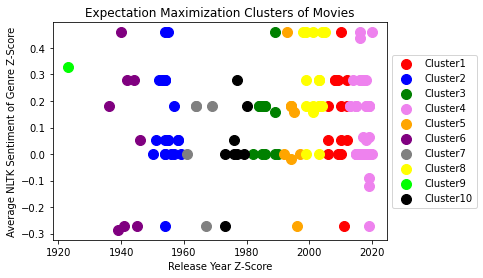

In [78]:
em = EM(n_components = 10, covariance_type = 'tied', init_params = 'kmeans', n_init = 10, random_state = 42)
Y_em = em.fit_predict(X)


plt.scatter(X[Y_em == 0, 0], X[Y_em == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_em == 1, 0], X[Y_em == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_em == 2, 0], X[Y_em == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_em == 3, 0], X[Y_em == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_em == 4, 0], X[Y_em == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_em == 5, 0], X[Y_em == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_em == 6, 0], X[Y_em == 6, 1], s = 100, color = 'gray', label = 'Cluster7')
plt.scatter(X[Y_em == 7, 0], X[Y_em == 7, 1], s = 100, color = 'yellow', label = 'Cluster8')
plt.scatter(X[Y_em == 8, 0], X[Y_em == 8, 1], s = 100, color = 'lime', label = 'Cluster9')
plt.scatter(X[Y_em == 9, 0], X[Y_em == 9, 1], s = 100, color = 'black', label = 'Cluster10')

# Add the centroids - Compute for EM, the centroid is point with the maximum density 
#centers = np.empty(shape=(em.n_components, X.shape[1]))
#for i in range(em.n_components):
#    density = scipy.stats.multivariate_normal(cov=em.covariances_[i], mean=em.means_[i]).logpdf(X)
#    centers[i, :] = X[np.argmax(density)]
#plt.scatter(centers[:, 0], centers[:, 1], s=20)

plt.title('Expectation Maximization Clusters of Movies')
plt.xlabel('Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The cluster 9 looks quite small. It may be better to have fewer clusters 

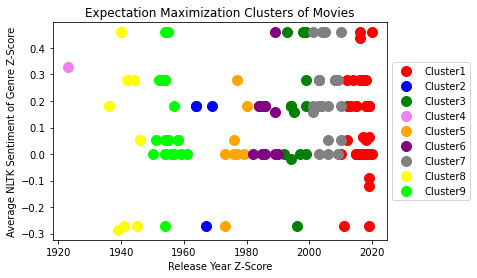

In [79]:
em = EM(n_components = 9, covariance_type = 'tied', init_params = 'kmeans', n_init = 10, random_state = 42)
Y_em = em.fit_predict(X)


plt.scatter(X[Y_em == 0, 0], X[Y_em == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_em == 1, 0], X[Y_em == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_em == 2, 0], X[Y_em == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_em == 3, 0], X[Y_em == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_em == 4, 0], X[Y_em == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_em == 5, 0], X[Y_em == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_em == 6, 0], X[Y_em == 6, 1], s = 100, color = 'gray', label = 'Cluster7')
plt.scatter(X[Y_em == 7, 0], X[Y_em == 7, 1], s = 100, color = 'yellow', label = 'Cluster8')
plt.scatter(X[Y_em == 8, 0], X[Y_em == 8, 1], s = 100, color = 'lime', label = 'Cluster9')

plt.title('Expectation Maximization Clusters of Movies')
plt.xlabel('Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [80]:
data['EM_Cluster'] = Y_em

### 3) Hierarchical Clustering 

#### Use Dendrogram to find optimal cluster size - Pick longest Vertical Line. Then, if a horizontal line was drawn through this line, how many cluster groups would we have? 

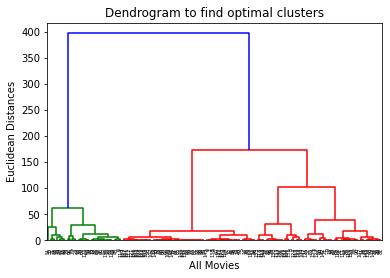

In [81]:
import scipy.cluster.hierarchy as sch

# Ward tries to minimize variance within cluster. Similar to WCSS for KMeans.
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward' ))

plt.title('Dendrogram to find optimal clusters')
plt.xlabel('All Movies')
plt.ylabel('Euclidean Distances')
plt.show()

- Pick line. Looks like 7 Clusters

#### Hierarchical Clustering with K = 7

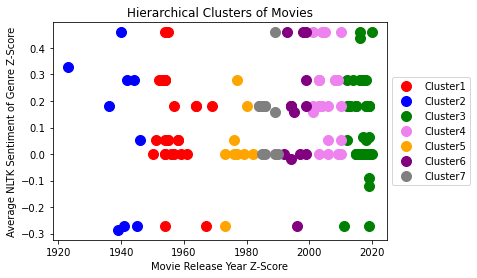

In [82]:
from sklearn.cluster import AgglomerativeClustering 

# Prepare hc algorithm 
hc = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage = 'ward')
Y_hc = hc.fit_predict(X)

plt.scatter(X[Y_hc == 0, 0], X[Y_hc == 0, 1], s = 100, color = 'red', label = 'Cluster1')
plt.scatter(X[Y_hc == 1, 0], X[Y_hc == 1, 1], s = 100, color = 'blue', label = 'Cluster2')
plt.scatter(X[Y_hc == 2, 0], X[Y_hc == 2, 1], s = 100, color = 'green', label = 'Cluster3')
plt.scatter(X[Y_hc == 3, 0], X[Y_hc == 3, 1], s = 100, color = 'violet', label = 'Cluster4')
plt.scatter(X[Y_hc == 4, 0], X[Y_hc == 4, 1], s = 100, color = 'orange', label = 'Cluster5')
plt.scatter(X[Y_hc == 5, 0], X[Y_hc == 5, 1], s = 100, color = 'purple', label = 'Cluster6')
plt.scatter(X[Y_hc == 6, 0], X[Y_hc == 6, 1], s = 100, color = 'gray', label = 'Cluster7')


plt.title('Hierarchical Clusters of Movies')
plt.xlabel('Movie Release Year Z-Score')
plt.ylabel('Average NLTK Sentiment of Genre Z-Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [83]:
data['Hierarchical_Cluster'] = Y_hc

In [84]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster
0,Star Wars: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0,0,2
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0,0,2
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0,0.5574,0.3612,0.4593,0.0,0.0,0.0,7,6,3
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.1806,0.0,0.0,0.0,2,2,5
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.1806,0.0,0.0,0.0,0,0,2


### Use Cluster Number, Movie Release Year, and Average NLTK Sentiment as Inputs into Decision Trees and other Regression Methods - See how this improves from earlier when we had no clusters 

Split Data

In [85]:
X_aug = data.loc[:, ['ReleaseYear','Romance_Ind', 'Comedy_Ind',
       'Drama_Ind', 'Thriller_Ind', 'Fantasy_Ind', 'Crime_Ind', 'Sport_Ind',
       'Historical_Ind', 'Mystery_Ind', 'Action_Ind', 'Musical_Ind',
       'SciFi_Ind', 'Other_Ind','Genre_NLTK','KMeans_Cluster']]
y_aug  = data.loc[:, 'Rating']

X_Train_aug, X_Test_aug, Y_Train_aug, Y_Test_aug = train_test_split(X_aug, y_aug, test_size = .30, train_size = .70, random_state = 42)
    

#### 1) Decision Tree with Augmented Data

In [86]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train_aug, Y_Train_aug)

Y_Test_Pred = dt_model.predict(X_Test_aug)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -0.8759312913907285
Mean Squared Error: 0.015736979166666665


Grid Search on New Datasets

In [87]:
#make_GridSearchCV_DT(X_Train_aug, Y_Train_aug)

R2 Score: -0.2600993377483447
Mean Squared Error: 0.010570833333333335


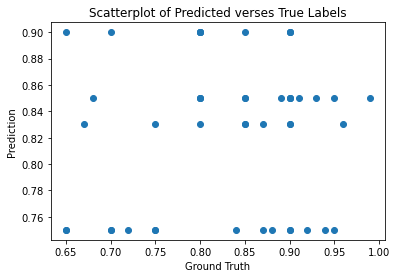

In [88]:
dt_model = DecisionTreeRegressor(criterion = 'mae', splitter = 'random', 
                                 max_depth = 5, min_samples_leaf = 13,
                                 random_state = 42)

dt_model.fit(X_Train_aug, Y_Train_aug)

Y_Test_Pred = dt_model.predict(X_Test_aug)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

plt.scatter(Y_Test_aug, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

This chart shows Decision Tree is only giving us 4 possible predicted values - which makes sense, given tree stops at depth of 3

#### 2) Boosted Decision Tree w/ Augmented Data

Default

In [89]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 50, learning_rate = 1.0, loss = 'linear', 
                                     random_state = 42)

#Y_Train = Y_Train.ravel()

boosted_dt_model.fit(X_Train_aug, Y_Train_aug)
Y_Test_Pred = boosted_dt_model.predict(X_Test_aug)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -0.34698532670588533
Mean Squared Error: 0.01129971024069937


In [90]:
#make_GridSearchCV_Boosted_DT(X_Train_aug, Y_Train_aug)

Best Params

R2 Score: -0.25038677813620236
Mean Squared Error: 0.010489355749920362


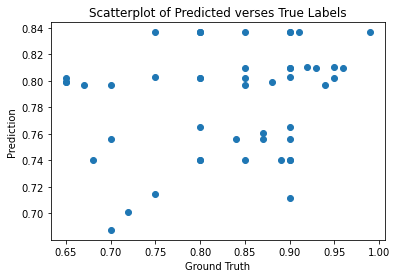

In [91]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 10, learning_rate = 0.9, loss = 'exponential', 
                                     random_state = 42)

#Y_Train = Y_Train.ravel()

boosted_dt_model.fit(X_Train_aug, Y_Train_aug)
Y_Test_Pred = boosted_dt_model.predict(X_Test_aug)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

plt.scatter(Y_Test_aug, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 3) Artificial Neural Network

Default

In [92]:
sc = StandardScaler()
X_Train_aug = sc.fit_transform(X_Train_aug)
X_Test_aug = sc.transform(X_Test_aug)

ann_model =  MLPRegressor(activation = 'relu', solver = 'adam', random_state = 42)

ann_model.fit(X_Train_aug, Y_Train_aug)

Y_Test_Pred = ann_model.predict(X_Test_aug)

print("R2 Score:", r2_score(Y_Test_aug, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_aug, Y_Test_Pred))

R2 Score: -2.7166172953490153
Mean Squared Error: 0.031178289533205627


In [93]:
#make_GridSearchCV_ANN(X_Train_aug, Y_Train_aug)

Best Params

R2 Score: -0.5059150664961396
Mean Squared Error: 0.012632954168939836


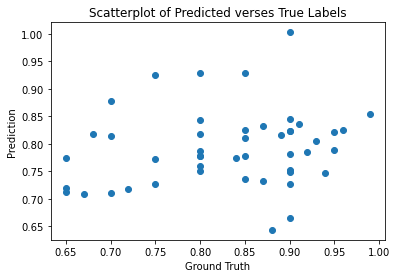

In [94]:
sc = StandardScaler()
X_Train_aug = sc.fit_transform(X_Train_aug)
X_Test_aug = sc.transform(X_Test_aug)

ann_model =  MLPRegressor(activation = 'identity', solver = 'adam', random_state = 42, \
                          hidden_layer_sizes = 15, learning_rate_init = 0.05)

ann_model.fit(X_Train_aug, Y_Train_aug)

Y_Test_Pred = ann_model.predict(X_Test_aug)

print("R2 Score:", r2_score(Y_Test_aug, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_aug, Y_Test_Pred))

plt.scatter(Y_Test_aug, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### Maybe it is a dimensionality problem? 


In [95]:
X_nlp = data.loc[:, ['ReleaseYear','Genre_NLTK','KMeans_Cluster']]
y_nlp  = data.loc[:, 'Rating']

X_Train_nlp, X_Test_nlp, Y_Train_nlp, Y_Test_nlp = train_test_split(X_nlp, y_nlp, test_size = .30, train_size = .70, random_state = 42)
    

#### 1) Decision Tree with 3 Dimensions

Defaults

In [96]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'best', 
                                 max_depth = None, min_samples_leaf = 1,
                                 random_state = 42)

dt_model.fit(X_Train_nlp, Y_Train_nlp)

Y_Test_Pred = dt_model.predict(X_Test_nlp)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

R2 Score: -1.2268982477924948
Mean Squared Error: 0.018681201967592594


In [97]:
#make_GridSearchCV_DT(X_Train_nlp, Y_Train_nlp)

Best Params

R2 Score: -0.3798085435406393
Mean Squared Error: 0.011575060559702028


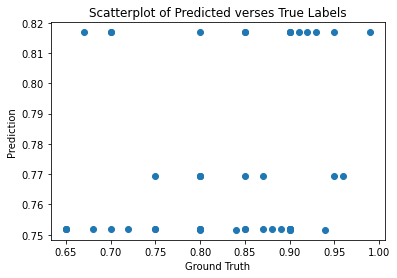

In [98]:
dt_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'random', 
                                 max_depth = 3, min_samples_leaf = 19,
                                 random_state = 42)

dt_model.fit(X_Train_nlp, Y_Train_nlp)

Y_Test_Pred = dt_model.predict(X_Test_nlp)

print("R2 Score:", r2_score(Y_Test, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test, Y_Test_Pred))

plt.scatter(Y_Test_nlp, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 2) Boosted Decision Tree with 3 Params

In [99]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 50, learning_rate = 1.0, loss = 'linear', 
                                     random_state = 42)


boosted_dt_model.fit(X_Train_nlp, Y_Train_nlp)
Y_Test_Pred = boosted_dt_model.predict(X_Test_nlp)

print("R2 Score:", r2_score(Y_Test_nlp, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_nlp, Y_Test_Pred))

R2 Score: -0.7919767697517388
Mean Squared Error: 0.015032694012917363


In [100]:
#make_GridSearchCV_Boosted_DT(X_Train_nlp, Y_Train_nlp)

R2 Score: -0.40203235814710414
Mean Squared Error: 0.011761493671122928


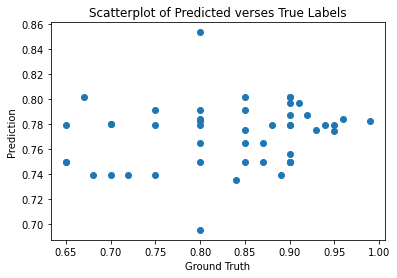

In [101]:
boosted_dt_model = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=3), 
                                     n_estimators = 10, learning_rate = 0.6, loss = 'linear', 
                                     random_state = 42)

boosted_dt_model.fit(X_Train_nlp, Y_Train_nlp)
Y_Test_Pred = boosted_dt_model.predict(X_Test_nlp)

print("R2 Score:", r2_score(Y_Test_nlp, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_nlp, Y_Test_Pred))

plt.scatter(Y_Test_nlp, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

#### 3) Artificial Neural Network

In [102]:
sc = StandardScaler()
X_Train_nlp = sc.fit_transform(X_Train_nlp)
X_Test_nlp = sc.transform(X_Test_nlp)

ann_model =  MLPRegressor(activation = 'relu', solver = 'adam', random_state = 42)

ann_model.fit(X_Train_nlp, Y_Train_nlp)

Y_Test_Pred = ann_model.predict(X_Test_nlp)

print("R2 Score:", r2_score(Y_Test_nlp, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_nlp, Y_Test_Pred))

R2 Score: -1.4543949582986966
Mean Squared Error: 0.02058964659461684


In [103]:
#make_GridSearchCV_ANN(X_Train_nlp, Y_Train_nlp)

R2 Score: -0.5406173672036592
Mean Squared Error: 0.012924067913764027


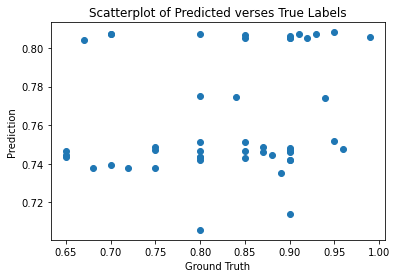

In [104]:
sc = StandardScaler()
X_Train_nlp = sc.fit_transform(X_Train_nlp)
X_Test_nlp = sc.transform(X_Test_nlp)

ann_model =  MLPRegressor(activation = 'logistic', solver = 'adam', random_state = 42,
                         hidden_layer_sizes = 70, learning_rate_init = 0.01)

ann_model.fit(X_Train_nlp, Y_Train_nlp)

Y_Test_Pred = ann_model.predict(X_Test_nlp)

print("R2 Score:", r2_score(Y_Test_nlp, Y_Test_Pred))
print("Mean Squared Error:",mean_squared_error(Y_Test_nlp, Y_Test_Pred))

plt.scatter(Y_Test_nlp, Y_Test_Pred)
plt.title('Scatterplot of Predicted verses True Labels')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.show()

### The Best result was using Boosted Decision Trees on the full dataset including Movie Release Year, NLTK Genre NLP Sentiment Score, KMeans Cluster Groups, and Genre Binary Indicators 

##### However, The R-Squared Value is negative. A negative R2 value means that a horizontal line is still a better predictor

In [105]:
data.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster
0,Star Wars: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0,0,2
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0,0,2
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0,0.5574,0.3612,0.4593,0.0,0.0,0.0,7,6,3
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.1806,0.0,0.0,0.0,2,2,5
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.1806,0.0,0.0,0.0,0,0,2


### Add IMBD Dataset for additional Dimensions 

In [106]:
meta = pd.read_csv('IMDB/movies_metadata.csv',
                  parse_dates = ['release_date'],
                  low_memory = False)

In [107]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [108]:
meta['release_date'].dtype

dtype('O')

In [109]:
meta['release_datetime'] = pd.to_datetime(meta['release_date'],  errors='coerce', infer_datetime_format=True)

In [110]:
meta['release_year'] = meta['release_datetime'].dt.year

In [111]:
meta['release_year'] = meta['release_year'].fillna(0)

In [112]:
meta.shape

(45466, 26)

#### Merge Datasets on Title Column

In [113]:
data2 = pd.merge(data, meta, left_on = ['Name', 'ReleaseYear'], right_on = ['title', 'release_year'], how = 'left')

In [114]:
data2.head()

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_datetime,release_year
0,Star Wars: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0,0,2,False,"{'id': 10, 'name': 'Star Wars Collection', 'po...",245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.starwars.com/films/star-wars-episod...,140607,tt2488496,en,Star Wars: The Force Awakens,Thirty years after defeating the Galactic Empi...,31.626013,/weUSwMdQIa3NaXVzwUoIIcAi85d.jpg,"[{'name': 'Lucasfilm', 'id': 1}, {'name': 'Tru...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-12-15,2.068224e+09,136.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Every generation has a story.,Star Wars: The Force Awakens,False,7.5,7993.0,2015-12-15,2015.0
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0,0,2,False,"{'id': 131635, 'name': 'The Hunger Games Colle...",160000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.thehungergames.movie/,131634,tt1951266,en,The Hunger Games: Mockingjay - Part 2,"With the nation of Panem in a full scale war, ...",26.628178,/w93GAiq860UjmgR6tU9h2T24vaV.jpg,"[{'name': 'Studio Babelsberg', 'id': 264}, {'n...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",2015-11-18,6.534283e+08,137.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The fire will burn forever.,The Hunger Games: Mockingjay - Part 2,False,6.6,4117.0,2015-11-18,2015.0
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0,0.5574,0.3612,0.4593,0.0,0.0,0.0,7,6,3,False,NaN,42000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",http://www.alongcamepolly.com/,5966,tt0343135,en,Along Came Polly,Reuben Feffer is a guy who's spent his entire ...,15.725542,/nIY4kvJTTnxoBR0wycrXng5MOYs.jpg,"[{'name': 'Jersey Films', 'id': 216}, {'name':...","[{'iso_3166_1': 'US', 'name': 'United States o...",2004-01-16,1.719634e+08,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"For the most cautious man on Earth, life is ab...",Along Came Polly,False,5.8,795.0,2004-01-16,2004.0
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.1806,0.0,0.0,0.0,2,2,5,False,NaN,55000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,13,tt0109830,en,Forrest Gump,A man with a low IQ has accomplished great thi...,48.307194,/yE5d3BUhE8hCnkMUJOo1QDoOGNz.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1994-07-06,6.779454e+08,142.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"The world will never be the same, once you've ...",Forrest Gump,False,8.2,8147.0,1994-07-06,1994.0
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.1806,0.0,0.0,0.0,0,0,2,False,NaN,28000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://www.thebigshortmovie.com/,318846,tt1596363,en,The Big Short,The men who made millions from a global econom...,13.143061,/p11Ftd4VposrAzthkhF53ifYZRl.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-12-11,1.333465e+08,130.0,"[{'iso_639_1': 'en', 'nam

In [115]:
data2['runtime'].isna().sum()

67

In [116]:
print(data.shape)
print(data2.shape)


(157, 31)
(159, 57)


In [117]:
data2

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_datetime,release_year
0,Star Wars: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0000,0.0000,0.00000,0.000000,0.0,0.000000,0,0,2,False,"{'id': 10, 'name': 'Star Wars Collection', 'po...",245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.starwars.com/films/star-wars-episod...,140607,tt2488496,en,Star Wars: The Force Awakens,Thirty years after defeating the Galactic Empi...,31.626013,/weUSwMdQIa3NaXVzwUoIIcAi85d.jpg,"[{'name': 'Lucasfilm', 'id': 1}, {'name': 'Tru...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-12-15,2.068224e+09,136.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Every generation has a story.,Star Wars: The Force Awakens,False,7.5,7993.0,2015-12-15,2015.0
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0,0.0000,0.0000,0.00000,0.000000,0.0,0.000000,0,0,2,False,"{'id': 131635, 'name': 'The Hunger Games Colle...",160000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.thehungergames.movie/,131634,tt1951266,en,The Hunger Games: Mockingjay - Part 2,"With the nation of Panem in a full scale war, ...",26.628178,/w93GAiq860UjmgR6tU9h2T24vaV.jpg,"[{'name': 'Studio Babelsberg', 'id': 264}, {'n...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",2015-11-18,6.534283e+08,137.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The fire will burn forever.,The Hunger Games: Mockingjay - Part 2,False,6.6,4117.0,2015-11-18,2015.0
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0,0.5574,0.3612,0.45930,0.000000,0.0,0.000000,7,6,3,False,NaN,42000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",http://www.alongcamepolly.com/,5966,tt0343135,en,Along Came Polly,Reuben Feffer is a guy who's spent his entire ...,15.725542,/nIY4kvJTTnxoBR0wycrXng5MOYs.jpg,"[{'name': 'Jersey Films', 'id': 216}, {'name':...","[{'iso_3166_1': 'US', 'name': 'United States o...",2004-01-16,1.719634e+08,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"For the most cautious man on Earth, life is ab...",Along Came Polly,False,5.8,795.0,2004-01-16,2004.0
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.18060,0.000000,0.0,0.000000,2,2,5,False,NaN,55000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,13,tt0109830,en,Forrest Gump,A man with a low IQ has accomplished great thi...,48.307194,/yE5d3BUhE8hCnkMUJOo1QDoOGNz.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1994-07-06,6.779454e+08,142.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"The world will never be the same, once you've ...",Forrest Gump,False,8.2,8147.0,1994-07-06,1994.0
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.18060,0.000000,0.0,0.000000,0,0,2,False,NaN,28000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://www.thebigshortmovie.com/,318846,tt1596363,en,The Big Short,The men who made millions from a global econom...,13.143061,/p11Ftd4VposrAzthkhF53ifYZRl.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2

#### Todo: de-dupe the new dataset, based on year or something else. 

In [118]:
data2 = data2.sort_values(by = 'vote_count', ascending = False)

In [119]:
data3 = data2.drop_duplicates(subset = ['Name','ReleaseYear', 'WatchDate'], keep = 'first') # this keeps the movie with more ratings, probably the movie I watched

In [120]:
data3.shape

(157, 57)

In [121]:
data3 = data3.sort_values(by = 'WatchDate', ascending = True)

In [122]:
data3

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_datetime,release_year
0,Star Wars: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0000,0.0000,0.00000,0.000000,0.0,0.000000,0,0,2,False,"{'id': 10, 'name': 'Star Wars Collection', 'po...",245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.starwars.com/films/star-wars-episod...,140607,tt2488496,en,Star Wars: The Force Awakens,Thirty years after defeating the Galactic Empi...,31.626013,/weUSwMdQIa3NaXVzwUoIIcAi85d.jpg,"[{'name': 'Lucasfilm', 'id': 1}, {'name': 'Tru...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-12-15,2.068224e+09,136.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Every generation has a story.,Star Wars: The Force Awakens,False,7.5,7993.0,2015-12-15,2015.0
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0,0.0000,0.0000,0.00000,0.000000,0.0,0.000000,0,0,2,False,"{'id': 131635, 'name': 'The Hunger Games Colle...",160000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.thehungergames.movie/,131634,tt1951266,en,The Hunger Games: Mockingjay - Part 2,"With the nation of Panem in a full scale war, ...",26.628178,/w93GAiq860UjmgR6tU9h2T24vaV.jpg,"[{'name': 'Studio Babelsberg', 'id': 264}, {'n...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",2015-11-18,6.534283e+08,137.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The fire will burn forever.,The Hunger Games: Mockingjay - Part 2,False,6.6,4117.0,2015-11-18,2015.0
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0,0.5574,0.3612,0.45930,0.000000,0.0,0.000000,7,6,3,False,NaN,42000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",http://www.alongcamepolly.com/,5966,tt0343135,en,Along Came Polly,Reuben Feffer is a guy who's spent his entire ...,15.725542,/nIY4kvJTTnxoBR0wycrXng5MOYs.jpg,"[{'name': 'Jersey Films', 'id': 216}, {'name':...","[{'iso_3166_1': 'US', 'name': 'United States o...",2004-01-16,1.719634e+08,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"For the most cautious man on Earth, life is ab...",Along Came Polly,False,5.8,795.0,2004-01-16,2004.0
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.18060,0.000000,0.0,0.000000,2,2,5,False,NaN,55000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,13,tt0109830,en,Forrest Gump,A man with a low IQ has accomplished great thi...,48.307194,/yE5d3BUhE8hCnkMUJOo1QDoOGNz.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1994-07-06,6.779454e+08,142.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"The world will never be the same, once you've ...",Forrest Gump,False,8.2,8147.0,1994-07-06,1994.0
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.18060,0.000000,0.0,0.000000,0,0,2,False,NaN,28000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://www.thebigshortmovie.com/,318846,tt1596363,en,The Big Short,The men who made millions from a global econom...,13.143061,/p11Ftd4VposrAzthkhF53ifYZRl.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2

In [123]:
meta['title'].head()

0                      Toy Story
1                        Jumanji
2               Grumpier Old Men
3              Waiting to Exhale
4    Father of the Bride Part II
Name: title, dtype: object

In [131]:
#meta[meta['title'].str.contains('Star Wars', na = False)]
#meta[meta['title'].str.contains('Hunger Games', na = False)]
#meta[meta['title'].str.contains('Strangelove', na = False)]
meta[meta['title'].str.contains('40 Year', na = False)]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_datetime,release_year
10301,False,NaN,26000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",http://www.universalstudiosentertainment.com/t...,6957,tt0405422,en,The 40 Year Old Virgin,Andy Stitzer has a pleasant life with a nice a...,11.519662,/kFXfr0ioXRfxz4AvQ6RJ7iFF6PI.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",2005-08-11,109449237.0,116.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"The longer you wait, the harder it gets",The 40 Year Old Virgin,False,6.2,2020.0,2005-08-11,2005.0


#### New Data

In [133]:
os.listdir()

['Movie_Rankings.csv',
 'imdb_updated',
 'Movies.ipynb',
 'Movies_2020.xlsx',
 '.DS_Store',
 'Archive',
 'Movies_Ranked.csv',
 'Movies_Updated.ipynb',
 'IMDB',
 '.ipynb_checkpoints',
 'Movies - Personal Inquiry.ipynb',
 'Movies.csv',
 'MLR_Movies.ipynb']

In [135]:
os.listdir('imdb_updated')

['title.principals.tsv.gz',
 'title.ratings.tsv',
 'title.akas.tsv.gz',
 '.DS_Store',
 'title.akas.tsv',
 'title.basics.tsv.gz',
 'title.crew.tsv.gz',
 'name.basics.tsv',
 'title.ratings.tsv.gz',
 'title.basics.tsv',
 'name.basics.tsv.gz',
 'title.episode.tsv',
 'title.crew.tsv',
 'title.episode.tsv.gz']

In [160]:
basics =  pd.read_csv('imdb_updated/title.basics.tsv', sep='\t', error_bad_lines=False)

/Users/amandahutter/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [161]:
basics.tail()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
7445319,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2010,\N,\N,"Action,Drama,Family"
7445320,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
7445321,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
7445322,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short
7445323,tt9916880,tvEpisode,Horrid Henry Knows It All,Horrid Henry Knows It All,0,2014,\N,10,"Animation,Comedy,Family"


In [162]:
basics.dtypes

tconst            object
titleType         object
primaryTitle      object
originalTitle     object
isAdult            int64
startYear         object
endYear           object
runtimeMinutes    object
genres            object
dtype: object

In [163]:
basics.shape

(7445324, 9)

In [164]:
basics.isna().sum()

tconst            0
titleType         0
primaryTitle      8
originalTitle     8
isAdult           0
startYear         0
endYear           0
runtimeMinutes    0
genres            9
dtype: int64

In [188]:
basics = basics[basics['startYear'] != '\\N']

basics = basics[basics['titleType'] == 'movie']

In [189]:
basics['startYear'] = basics['startYear'].astype(int)

In [190]:
print(min(basics['startYear']))
print(max(basics['startYear']))

1894
2028


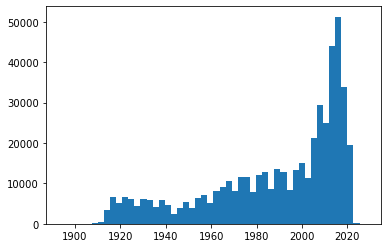

In [191]:
plt.hist(basics['startYear'], bins = 50)
plt.show()

##### Try this merge 

In [192]:
data5 = pd.merge(data, basics, left_on = ['Name', 'ReleaseYear'], right_on = ['primaryTitle', 'startYear'], how = 'left')


In [193]:
data5.shape


(160, 40)

In [194]:
data5

,Name,Rating,WatchDate,ReleaseYear,Director,Genre,WatchMonth,Genre1,Genre2,Romance_Ind,Comedy_Ind,Drama_Ind,Thriller_Ind,Fantasy_Ind,Crime_Ind,Sport_Ind,Historical_Ind,Mystery_Ind,Action_Ind,Musical_Ind,SciFi_Ind,Other_Ind,Genre1_NLTK,Genre2_NLTK,Genre_NLTK,Genre1_TB,Genre2_TB,Genre_TB,KMeans_Cluster,EM_Cluster,Hierarchical_Cluster,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,Star Wars: The Force Awakens,0.85,2016-01-01,2015,Abrams,Fantasy/ScienceFiction,2016-01-01,Fantasy,ScienceFiction,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0000,0.0000,0.00000,0.000000,0.0,0.000000,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Hunger Games: Mockingjay - Part 2,0.65,2016-01-04,2015,Lawrence,Fantasy/Drama,2016-01-01,Fantasy,Drama,0,0,1,0,1,0,0,0,0,0,0,0,0,0.0000,0.0000,0.00000,0.000000,0.0,0.000000,0,0,2,tt1951266,movie,The Hunger Games: Mockingjay - Part 2,The Hunger Games: Mockingjay - Part 2,0.0,2015.0,\N,137,"Action,Adventure,Sci-Fi"
2,Along Came Polly,0.65,2016-01-08,2004,Hamburg,Romance/Comedy,2016-01-01,Romance,Comedy,1,1,0,0,0,0,0,0,0,0,0,0,0,0.5574,0.3612,0.45930,0.000000,0.0,0.000000,7,6,3,tt0343135,movie,Along Came Polly,Along Came Polly,0.0,2004.0,\N,90,"Comedy,Romance"
3,Forrest Gump,0.95,2016-01-10,1994,Zemeckis,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.18060,0.000000,0.0,0.000000,2,2,5,tt0109830,movie,Forrest Gump,Forrest Gump,0.0,1994.0,\N,142,"Drama,Romance"
4,The Big Short,0.95,2016-01-14,2015,McKay,Comedy/Drama,2016-01-01,Comedy,Drama,0,1,1,0,0,0,0,0,0,0,0,0,0,0.3612,0.0000,0.18060,0.000000,0.0,0.000000,0,0,2,tt1596363,movie,The Big Short,The Big Short,0.0,2015.0,\N,130,"Biography,Comedy,Drama"
5,Magic in the Moonlight,0.40,2016-01-17,2014,Allen,Romance/Drama,2016-01-01,Romance,Drama,1,0,1,0,0,0,0,0,0,0,0,0,0,0.5574,0.0000,0.27870,0.000000,0.0,0.000000,8,0,2,tt2870756,movie,Magic in the Moonlight,Magic in the Moonlight,0.0,2014.0,\N,97,"Comedy,Drama,Romance"
6,Sunset Boulevard,0.55,2016-01-19,1950,Wilder,Drama/Musical,2016-01-01,Drama,Musical,0,0,1,0,0,0,0,0,0,0,1,0,0,0.0000,0.0000,0.00000,0.000000,0.0,0.000000,1,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Dr. Strangelove or: How I Learned to Stop Worr...,0.50,2016-01-20,1964,Kubrick,Fantasy/Comedy,2016-01-01,Fantasy,Comedy,0,1,0,0,1,0,0,0,0,0,0,0,0,0.0000,0.3612,0.18060,0.000000,0.0,0.000000,1,1,0,tt0057012,movie,Dr. Strangelove or: How I Learned to Stop Worr...,Dr. Strangelove or: How I Learned to Stop Worr...,0.0,1964.0,\N,95,Comedy
8,The Sting,0.80,2016-01-21,1973,Hill,Crime/Drama,2016-01-01,Crime,Drama,0,0,1,0,0,1,0,0,0,0,0,0,0,-0.5423,0.0000,-0.27115,0.000000,0.0,0.000000,3,4,4,tt0070735,movie,The Sting,The Sting,0.0,1973.0,\N,129,"Comedy,Crime,Drama"
9,Fight Club,0.90,2016-01-29,1999,Fincher,Action/Drama,2016-01-01,Action,Drama,0,0,1,0,0,0,0,0,0,1,0,0,0,0.0000,0.0000,0.00000,0.100000,0.0,0.050000,7,2,5,tt0137523,movie,Fight Club,Fight Club,0.0,1999.0,\N,139,Drama


In [195]:
data5['runtimeMinutes'].isna().sum()

54

In [198]:
basics[basics['primaryTitle'].str.contains('Sunset B', na = False)]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
42272,tt0043014,movie,Sunset Blvd.,Sunset Blvd.,0,1950,\N,110,"Drama,Film-Noir"
79005,tt0080704,movie,Exit Sunset Boulevard,Exit Sunset Boulevard,0,1980,\N,94,Drama
111585,tt0114075,movie,The Sunset Boys,Pakten,0,1995,\N,96,"Comedy,Crime,Drama"
199899,tt0208014,movie,Sunset Boulevards,"Boulevards du crépuscule: Sur Falconetti, Le V...",0,1992,\N,\N,Documentary
905541,tt0934361,movie,24/7 - Sunset Boulevard,24/7 - Sunset Boulevard,0,2002,\N,90,Drama
3152684,tt1451753,movie,Far from Sunset Boulevard,Daleko ot Sanset Bulvara,0,2006,\N,130,Drama
3175534,tt1475415,movie,Sunset Bollywood,Sunset Bollywood,0,2005,\N,60,Documentary
5023519,tt4660628,movie,Sunset Blues,Sunset Blues,0,2009,\N,59,Animation
